<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Optimization-based-controller" data-toc-modified-id="Optimization-based-controller-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Optimization based-controller</a></span></li></ul></li></ul></li><li><span><a href="#Synthesis-2" data-toc-modified-id="Synthesis-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Synthesis 2</a></span><ul class="toc-item"><li><span><a href="#Data-Structure" data-toc-modified-id="Data-Structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Structure</a></span><ul class="toc-item"><li><span><a href="#A-pool-of-controllers" data-toc-modified-id="A-pool-of-controllers-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>A pool of controllers</a></span></li></ul></li><li><span><a href="#Synthesis2:-Convex-Optimization" data-toc-modified-id="Synthesis2:-Convex-Optimization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Synthesis2: Convex Optimization</a></span></li></ul></li></ul></div>

In this notebook, I explore a new technique for synthesizing controller. The gist of this new technique is that: rather than trying to find the closed-loop mappings $\{R, M, N, L\}$, or rather, their impulse responses, directly, we find a convex combination of known controllers that satisfies the specification. 

The expected advantages of this method is mainly computational. Synthesis1--the previous approach--couldn't solve for responses with impulse mappings longer than 374 even for the modest 1-dof problem I throw at it. This is a clear disadvantage.

In [16]:
# previous synthesis script
from Oct23_1dof_admittance import plant, analysis
# standard libs
import SLSsyn as Ss
import numpy as np
import control as co
import matplotlib.pyplot as plt

In [2]:
# constants
dT = 0.008

The nominal model is that of a human with a *net stiffness* of 50 (N/m), and slight time delay of 0.05 second. This model can be found below.

A remarkable, and unfortunate, fact is that even for this 
relatively simple model with a single robot joint, the nominal model has 9 states. You can check this by looking at the shape of matrix A of `Pssd_design`. 

The reason why this is unfortunate is that the response mapping $R$ is a $nx\times nx$ transfer matrix that contains, in this simple case, 81 different transfer function. Even if all of them are stable, you need a large computational power to get hold of them.



In [3]:
Ptf_design = plant(Hdelay=0.05, Hgain=50)
Pss_design = Ss.tf2ss(Ptf_design, minreal=True)
Pssd_design = co.c2d(Pss_design, dT)

-- Trying to start matlab engine!
-- Matlab Engine started successfully!


Consider the following Admittance controller 
$$
   \frac{u}{y} = \frac{1}{s^2 + 6s + 5}
$$

In [4]:
def proc_ctrl(A1c):
    A1d = co.c2d(A1c, dT)
    A1dss = Ss.mtf2ss(A1d, minreal=True)
    return A1dss

A1c = co.tf([1], [1, 6, 5])
A1dss = proc_ctrl(A1c)
print(A1dss)

A = [[ 1.95282135 -0.95313379]
 [ 1.          0.        ]]

B = [[0.0078125]
 [0.       ]]

C = [[0.00403114 0.00396715]]

D = [[0.]]

dt = 0.008



The SLS closed-loop mapping can be computed using equation (21) in (Wang, 2016).

In [5]:
# function: compute_closed_loop_mappings R, N, M, L
nu = A1dss.outputs
ny = A1dss.inputs
nxc = A1dss.states
nx = Pssd_design.states

# form the state-space form of the combined closed-loop mappings transfer function
A, B1, B2, C1, C2, D11, D12, D21, D22 = map(np.array, Ss.get_partitioned_mats(Pssd_design, nu, ny))
Ak, Bk, Ck, Dk = A1dss.A, A1dss.B, A1dss.C, A1dss.D
assert np.all(D22 == 0)

# Concatenate system matrices to find the matrices of the ss rep of the impulse response mapping
# [R N] =   A_cb  |  B_cb
# [M L]     ------|-------
#           C_cb  |  D_cb
A_cb = np.block([[A + B2.dot(Dk).dot(C2), B2.dot(Ck)],
                 [Bk.dot(C2), Ak]])
B_cb = np.block([[np.eye(nx), B2.dot(Dk)],
                 [np.zeros((nxc, nx)), Bk]])
C_cb = np.block([[np.eye(nx), np.zeros((nx, nxc))],
                 [Dk.dot(C2), Ck]])
D_cb = np.block([[np.zeros((nx, nx)), np.zeros((nx, ny))],
                 [np.zeros((nu, nx)), Dk]])
resp_dss = co.ss(A_cb, B_cb, C_cb, D_cb, dT)

Having now obtained a state-space system that is equivalent to the SLS mapping, that is the following block transfer function
$$
   \begin{bmatrix}
    x \\ u
   \end{bmatrix}
    = 
   \begin{bmatrix}
      R & N \\ M & L
   \end{bmatrix}
   \begin{bmatrix}
   \delta x \\ \delta y
   \end{bmatrix}
$$

We can now compute the impulse response of this system.

It is important to note that the final impulse responses is a three dimensional array. The first dimension is time. The last two dimensions contain the entries of the matrices.

In [6]:
%%capture
# Compute impulse responses of the matrices
Tarr = np.arange(0, 3, dT)  # 5 sec horizon 
NT = Tarr.shape[0]
impulses = []
for i in range(nx + ny):
    _, yarr = co.impulse_response(resp_dss, Tarr, input=i, transpose=True)
    impulses.append(yarr)
impulse_full = np.stack(impulses, axis=2)

# Individual responses
R = impulse_full[:, :nx, :nx]
N = impulse_full[:, :nx, nx:nx + ny]
M = impulse_full[:, nx:nx + nu, :nx]
L = impulse_full[:, nx:nx + nu, nx:nx + ny]
MB2 = M@B2

Now we can visualize the impulse that make up the controller. Interesting.

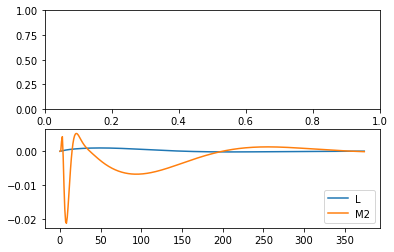

In [7]:
fig, axs = plt.subplots(2, 1)
plt.plot(L.reshape(NT, -1), label='L')
plt.plot(MB2.reshape(NT, -1), label='M2')
plt.legend()
plt.show()

Since the system is stable, a controller can be formed from only the two respones 
L and MB2 that achieves exactly the given closed-loop mapping. To verify that this is indeed the case, we take the reponses L and MB2, form a controller, simulate a response and compare that to the step response of the original system.

In [8]:
# from the two responses L and MB2, we now FIR-based controller
fir_den = [1] + [0 for n in range(NT - 1)]
MB2_tf = co.tf(MB2[:, 0, 0], fir_den, dT)
L_tf = co.tf(L[:, 0, 0], fir_den, dT)
A1dss_FIR = co.feedback(1, MB2_tf, sign=-1) * L_tf
A1dss_FIR = Ss.mtf2ss(A1dss_FIR, minreal=False)

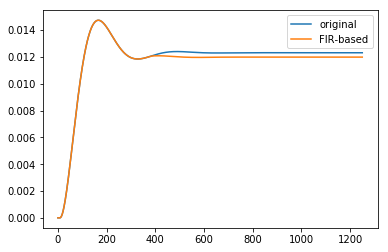

In [9]:
# Original system
Pdss_cl = Ss.lft(Pssd_design, A1dss)
_, yout_step = co.step_response(Pdss_cl, [0, 10], transpose=True)
# FIR-based system
Pdss_cl_FIR = Ss.lft(Pssd_design, A1dss_FIR)
_, yout_step_FIR = co.step_response(Pdss_cl_FIR, [0, 10], transpose=True)

plt.plot(yout_step[:, 0], label='original')
plt.plot(yout_step_FIR[:, 0], label='FIR-based')
plt.legend()
plt.show()

### Optimization based-controller

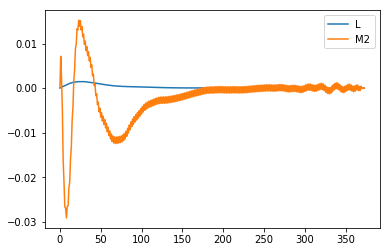

In [190]:
# controller from direct optimization of the impulses
import yaml
with open("../config/super.yaml", 'r') as f:
    doc = yaml.load(f)
L = np.array(doc['fir_siso']['super']['L']).reshape(-1, 1, 1)
MB2 = np.array(doc['fir_siso']['super']['MB2']).reshape(-1, 1, 1)
T = L.shape[0]

plt.plot(L[:, 0, 0], label='L')
plt.plot(MB2[:, 0, 0], label='M2')
plt.legend()
plt.show()

# Synthesis 2

## Data Structure

In the following we devise a class to represent a controller, which encapsulates the above
argument and contains some helpful tricks to make the synthesis smoother.

In the following cell *all* necessary classes and fucntions are defined. The later cells contain only
execution scripts, which are broken down into separated cells only for readability.


In [15]:
class AtomicFIRController(object):
    """
    """
    nb_atoms = 0
    def __init__(self):
        # do nothing
        self.name = "atom nb.{:d}".format(AtomicFIRController.nb_atoms)
        AtomicFIRController.nb_atoms += 1
        
    @staticmethod
    def init_as_convex_comb(weights, controllers):
        self = AtomicFIRController()
        self.exec_ctrl = None
        assert len(weights) == len(controllers)
        # normalize
        self.weights = np.abs(weights) / np.sum(np.abs(weights))
        
        # basic parameters
        self.T = controllers[0].T
        self.dt = controllers[0].dt
        self.NT = controllers[0].NT
        self.nx = controllers[0].nx
        self.ny = controllers[0].ny
        self.nxc =controllers[0].nxc
        self.nu = controllers[0].nu
        self.ny = controllers[0].ny
       
        # responses
        self.R = 0
        self.N = 0
        self.M = 0
        self.L = 0
        self.MB2 = 0
        self.H = 0
        for wi, ctrli in zip(self.weights, controllers):
            self.R += wi * ctrli.R
            self.N += wi * ctrli.N
            self.M += wi * ctrli.M
            self.L += wi * ctrli.L
            self.MB2 += wi * ctrli.MB2
            self.H += wi * ctrli.H
        return self
        
    @staticmethod
    def init_via_simulation(Pssd_design, A1dss, T=5):
        self = AtomicFIRController()
        nu = A1dss.outputs
        ny = A1dss.inputs
        nxc = A1dss.states
        nx = Pssd_design.states
        dT = Pssd_design.dt
        self.T = T
        self.dt = dT
        self.NT = int(T / dT)
        self.nx = nx
        self.ny = ny
        self.nxc = nxc
        self.nu = nu
        self.ny = ny
        
        # executable controller
        self.exec_ctrl = A1dss

        # closed-loop response, check stability
        Pssd_cl = Pssd_design.lft(A1dss)
        w, q = np.linalg.eig(Pssd_cl.A)
        wmax = w[np.argmax(np.abs(w))]
        if np.abs(wmax) > 1:
            print(" -- Closed-loop system UNSTABLE. w_max={:}"
                  " ----> Return None".format(wmax))
            return None
        else:
            print(" -- Closed-loop system STABLE. w_max={:}".format(wmax))
        
        A, B1, B2, C1, C2, D11, D12, D21, D22 = map(np.array, Ss.get_partitioned_mats(
            Pssd_design, nu, ny))
        Ak, Bk, Ck, Dk = A1dss.A, A1dss.B, A1dss.C, A1dss.D
        assert np.all(D22 == 0)

        # Concatenate system matrices to find the matrices of the ss rep of the impulse response mapping
        # [R N] =   A_cb  |  B_cb
        # [M L]     ------|-------
        #           C_cb  |  D_cb
        A_cb = np.block([[A + B2.dot(Dk).dot(C2), B2.dot(Ck)],
                         [Bk.dot(C2), Ak]])
        B_cb = np.block([[np.eye(nx), B2.dot(Dk)],
                         [np.zeros((nxc, nx)), Bk]])
        C_cb = np.block([[np.eye(nx), np.zeros((nx, nxc))],
                         [Dk.dot(C2), Ck]])
        D_cb = np.block([[np.zeros((nx, nx)), np.zeros((nx, ny))],
                         [np.zeros((nu, nx)), Dk]])
        resp_dss = co.ss(A_cb, B_cb, C_cb, D_cb, dT)

        # Compute impulse responses of the matrices
        Tarr = np.arange(0, T, dT)  # 5 sec horizon 
        NT = Tarr.shape[0]
        impulses = []
        for i in range(nx + ny):
            _, yarr = co.impulse_response(resp_dss, Tarr, input=i, transpose=True)
            impulses.append(yarr)
        impulse_full = np.stack(impulses, axis=2)

        # Individual responses
        self.R = impulse_full[:, :nx, :nx]
        self.N = impulse_full[:, :nx, nx:nx + ny]
        self.M = impulse_full[:, nx:nx + nu, :nx]
        self.L = impulse_full[:, nx:nx + nu, nx:nx + ny]
        self.MB2 = self.M@B2
        
        # Output responses H (from control input w to output z)
        _, self.H = co.impulse_response(Pssd_cl, Tarr, transpose=True)
        _, self.H_step = co.step_response(Pssd_cl, Tarr, transpose=True)
        
        # frequency response of the mapping
        W = Ss.dft_matrix(self.NT)
        self.H_fft = W@self.H
        return self
    
    def get_executable_controller(self):
        if self.exec_ctrl:
            return self.exec_ctrl
        else:
            fir_den = [1] + [0 for n in range(NT - 1)]
            MB2_tf = co.tf(self.MB2[:, 0, 0], fir_den, dT)
            L_tf = co.tf(self.L[:, 0, 0], fir_den, dT)
            A1dss_FIR = co.feedback(1, MB2_tf, sign=-1) * L_tf
            A1dss_FIR = Ss.mtf2ss(A1dss_FIR, minreal=False)
            self.exec_ctrl = A1dss_FIR
            return self.exec_ctrl

def analysis_plot(atoms):
    """ Plot defining characteristics.
    
    impulse plot | dft plots
    -------------------------
    step resp    |
    """
    fix, axs = plt.subplots(2, 2)
    
    for i, atom in enumerate(atoms):
        axs[0, 0].plot(atom.H[:, 0], label=atom.name, c="C{:d}".format(i))
        axs[1, 0].plot(atom.H_step[:, 0], label=atom.name, c="C{:d}".format(i))
    axs[0, 0].legend()
    axs[1, 0].legend()
    plt.show()
    

### A pool of controllers

In synthesis2, we try to synthesize controllers as affine combinations of multiple controllers. These controllers, which are referred to as basis controllers, are chosen as shown below.

In [11]:
# controller pools
ctrl_pool = [
    co.tf([1], [0.1, 1, 1]),  # this controller should be unstable
    co.tf([1], [1, 4, 6]),
    co.tf([1], [0.1, 6, 6]),
    co.tf([0], [1]),  # zero controller
    co.tf([0.001], [1]),
    co.tf([0.01], [1, 1])
]
report_string = "Controllers pool contain: {:d} controllers\n".format(len(ctrl_pool))
for i, c in enumerate(ctrl_pool):
    report_string += "> [c{:d}] {:}".format(i, repr(c))
# print(report_string)

In [12]:
# Now, generate the responses for each controller in the pool. Those that are not
# stabilizing are excluded.
%%capture
atomic_pool = {}
for i, ctrl in enumerate(ctrl_pool):
    atomic = AtomicFIRController.init_via_simulation(Pssd_design, proc_ctrl(ctrl))
    if atomic is not None:
        atomic.name = "c{:d}".format(i)
        atomic_pool[atomic.name] = atomic

In [13]:
report_string = "-- {:d}/{:d} controllers in controllers pool are stabilizing".format(len(atomic_pool), len(ctrl_pool))
print(report_string)
print(atomic_pool.keys())

-- 5/6 controllers in controllers pool are stabilizing
dict_keys(['c5', 'c3', 'c2', 'c4', 'c1'])


## Synthesis2: Convex Optimization

We will now find an affine combination of the atomic controllers in the controller pool that will satisfy two constraints: first, robust stability, second, noise attenuation and also optimize a cost function that make the system behave like an ideal mass spring damper.